# 2D DPP conforming Galerkin FEM

In [1]:
import os
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "1"

import firedrake as fd
import petsc4py
import numpy as np
from scipy.sparse import csr_matrix
from scipy.linalg import svd
from scipy.sparse.linalg import svds

For convenience, we define the operators from Firedrake:

In [2]:
grad = fd.grad
div = fd.div
dx = fd.dx
inner = fd.inner
pi = fd.pi
sin = fd.sin
exp = fd.exp
cos = fd.cos

## Case 1

### Exact solutions

In [3]:
# 1) Create a mesh and function‐spaces.  For example, a unit square:
num_elements_x, num_elements_y = 50, 50
enable_run_on_quads = True
mesh = fd.UnitSquareMesh(
    num_elements_x,
    num_elements_y,
    quadrilateral=enable_run_on_quads,
)

# Vector‐valued H1 space for velocity, and scalar CG1 space for pressure:
V = fd.VectorFunctionSpace(mesh, "CG", 1)
Q = fd.FunctionSpace(mesh, "CG", 1)

# 2) Declare SpatialCoordinate and all parameters:
x, y = fd.SpatialCoordinate(mesh)

# Physical / problem parameters (you can change these as needed):
k1 = fd.Constant(1.0e0)  # example value for k1
k2 = k1 / 1e2  # example value for k2
beta = fd.Constant(1.0e0)  # example value for β
mu = fd.Constant(1.0e0)  # example value for μ

# Define η = sqrt(β (k1 + k2) / (k1 k2))
eta = fd.sqrt(beta * (k1 + k2) / (k1 * k2))

# 3) Build the UFL expressions for u1, p1, u2, p2 exactly as given:
u1_expr = fd.as_vector(
    [
        -k1 * (exp(pi * x) * sin(pi * y)),
        -k1 * (exp(pi * x) * cos(pi * y) - (eta / (beta * k1)) * exp(eta * y)),
    ]
)

p1_expr = (mu / pi) * exp(pi * x) * sin(pi * y) - (mu / (beta * k1)) * exp(eta * y)

u2_expr = fd.as_vector(
    [
        -k2 * (exp(pi * x) * sin(pi * y)),
        -k2 * (exp(pi * x) * cos(pi * y) + (eta / (beta * k2)) * exp(eta * y)),
    ]
)

p2_expr = (mu / pi) * exp(pi * x) * sin(pi * y) + (mu / (beta * k2)) * exp(eta * y)

# 4) Now interpolate each analytic expression into a Firedrake Function:
u1_exact = fd.Function(V, name="u1_analytic")
u1_exact.interpolate(u1_expr)

p1_exact = fd.Function(Q, name="p1_analytic")
p1_exact.interpolate(p1_expr)

u2_exact = fd.Function(V, name="u2_analytic")
u2_exact.interpolate(u2_expr)

p2_exact = fd.Function(Q, name="p2_analytic")
p2_exact.interpolate(p2_expr)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x788bef1b00a0>, FiniteElement('Q', quadrilateral, 1), name=None), Mesh(VectorElement(FiniteElement('Q', quadrilateral, 1), dim=2), 0)), 15)

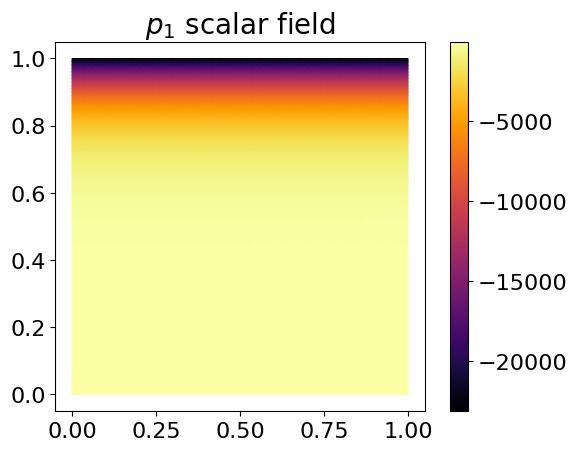

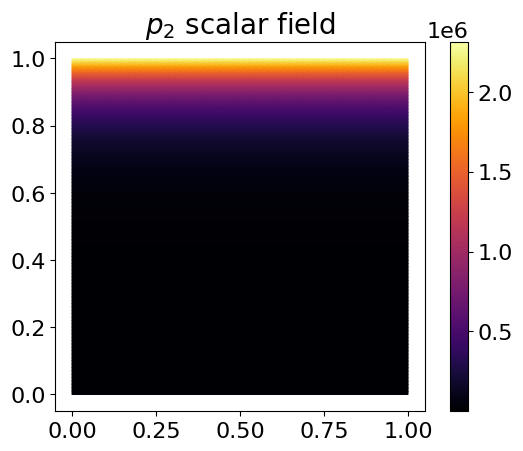

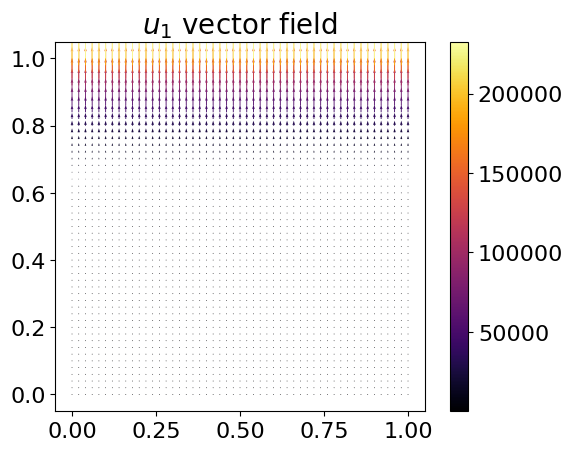

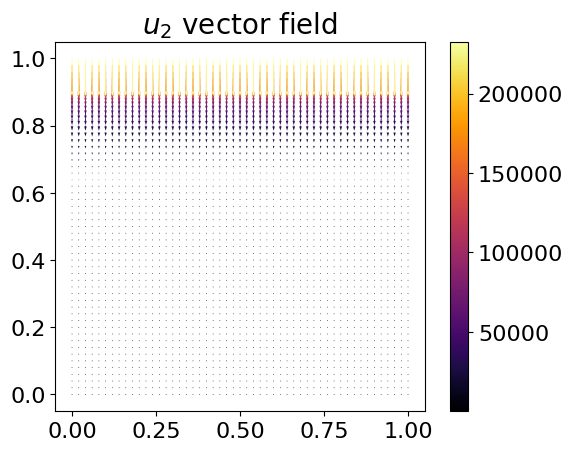

In [4]:
fig, axes = plt.subplots()
contours = fd.tripcolor(p1_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$p_1$ scalar field")
fig.colorbar(contours)
plt.show()

fig, axes = plt.subplots()
contours = fd.tripcolor(p2_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$p_2$ scalar field")
fig.colorbar(contours)
plt.show()

fig, axes = plt.subplots()
contours = fd.quiver(u1_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$u_1$ vector field")
fig.colorbar(contours)
plt.show()

fig, axes = plt.subplots()
contours = fd.quiver(u2_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$u_2$ vector field")
fig.colorbar(contours)
plt.show()

### Conforming Galerkin FEM approximations

#### Monolithic (fully coupled) approximation

In [5]:
# Approximation degree
degree = 1

# Function space declaration
pressure_family = "CG"
velocity_family = "CG"
U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
V = fd.FunctionSpace(mesh, pressure_family, degree)
W = V * V

# Trial and test functions
p1, p2 = fd.TrialFunctions(W)
q1, q2 = fd.TestFunctions(W)

# Forcing function
f = fd.Constant(0.0)

# Dirichlet BCs
bc_macro = fd.DirichletBC(W.sub(0), p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(W.sub(1), p2_exact, "on_boundary")
bcs = [bc_macro, bc_micro]

# Variational form
## Mass transfer term
xi = -beta / mu * (p1 - p2)

## Macro terms
a = (k1 / mu) * inner(grad(p1), grad(q1)) * dx - xi * q1 * dx
L = f * q1 * dx

## Micro terms
a += (k2 / mu) * inner(grad(p2), grad(q2)) * dx + xi * q2 * dx
L += f * q2 * dx

# Solving the problem
solver_parameters = {
    "mat_type": "aij",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
}
solution = fd.Function(W)
problem = fd.LinearVariationalProblem(a, L, solution, bcs=bcs, constant_jacobian=True)
solver = fd.LinearVariationalSolver(problem, solver_parameters=solver_parameters)
solver.solve()

# Retrieving the solution
p1_h = fd.Function(V, name="p1_h")
p2_h = fd.Function(V, name="p2_h")
p1_h.assign(solution.sub(0))
p2_h.assign(solution.sub(1))
u1_h = fd.project(-grad(p1_h), U)
u2_h = fd.project(-grad(p2_h), U)

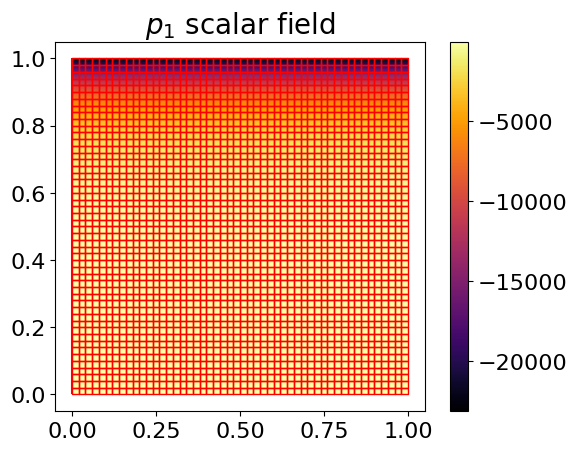

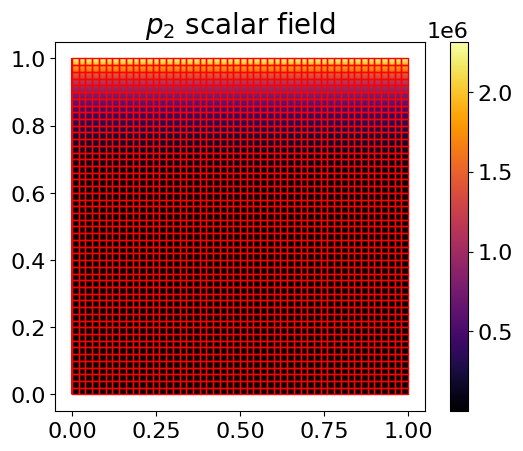

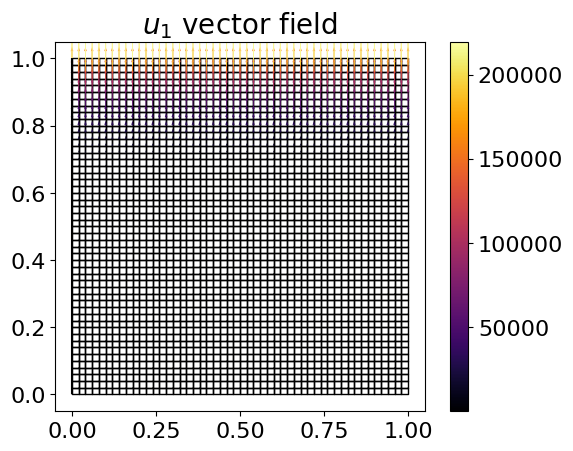

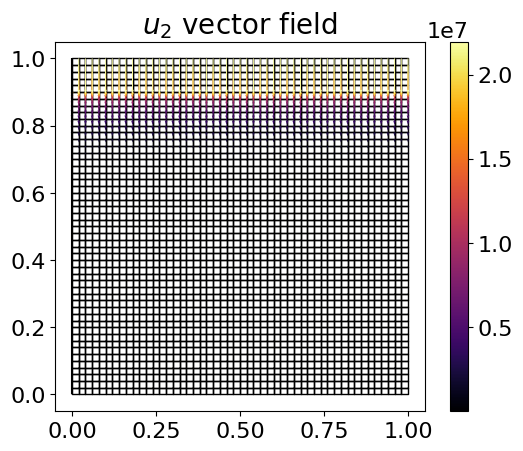

In [6]:
fig, axes = plt.subplots()
colors = fd.tripcolor(p1_h, axes=axes, cmap="inferno")
fd.triplot(
    mesh, axes=axes, interior_kw={"edgecolors": "red"}, boundary_kw={"colors": "red"}
)
axes.set_aspect("equal")
axes.set_title(r"$p_1$ scalar field")
fig.colorbar(colors)
plt.show()

fig, axes = plt.subplots()
colors = fd.tripcolor(p2_h, axes=axes, cmap="inferno")
fd.triplot(
    mesh, axes=axes, interior_kw={"edgecolors": "red"}, boundary_kw={"colors": "red"}
)
axes.set_aspect("equal")
axes.set_title(r"$p_2$ scalar field")
fig.colorbar(colors)
plt.show()

fig, axes = plt.subplots()
fd.triplot(mesh, axes=axes, boundary_kw={"colors": "k"})
colors = fd.quiver(u1_h, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$u_1$ vector field")
fig.colorbar(colors)
plt.show()

fig, axes = plt.subplots()
fd.triplot(mesh, axes=axes, boundary_kw={"colors": "k"})
colors = fd.quiver(u2_h, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$u_2$ vector field")
fig.colorbar(colors)
plt.show()

In [7]:
def get_xy_coordinate_points(function_space, mesh):
    x, y = fd.SpatialCoordinate(mesh)

    xfunc = fd.Function(function_space).interpolate(x)
    x_points = np.unique(np.array(xfunc.dat.data))

    yfunc = fd.Function(function_space).interpolate(y)
    y_points = np.unique(np.array(yfunc.dat.data))

    return x_points, y_points


def retrieve_solution_on_line_fixed_x(solution, function_space, mesh, x_value):
    _, y_points = get_xy_coordinate_points(function_space, mesh)
    solution_on_a_line = [solution.at([x_value, y_point]) for y_point in y_points]
    solution_on_a_line = np.array(solution_on_a_line)
    return solution_on_a_line

In [8]:
# Fixed x-point coordinate to slice the solution
x_points, y_points = get_xy_coordinate_points(V, mesh)
x_mid_point = (x_points.min() + x_points.max()) / 2

p1_at_x_mid_point = retrieve_solution_on_line_fixed_x(p1_h, V, mesh, x_mid_point)

p2_at_x_mid_point = retrieve_solution_on_line_fixed_x(p2_h, V, mesh, x_mid_point)

p1_exact_at_x_mid_point = retrieve_solution_on_line_fixed_x(
    p1_exact, V, mesh, x_mid_point
)

p2_exact_at_x_mid_point = retrieve_solution_on_line_fixed_x(
    p2_exact, V, mesh, x_mid_point
)

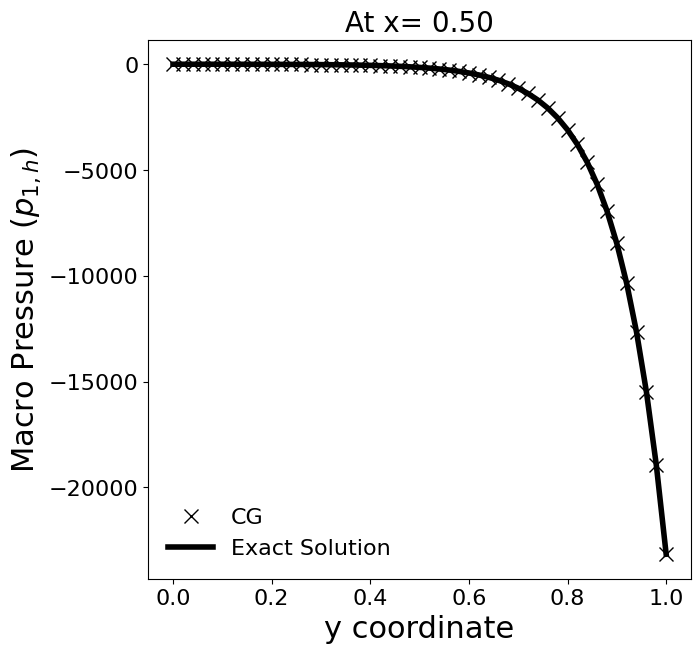

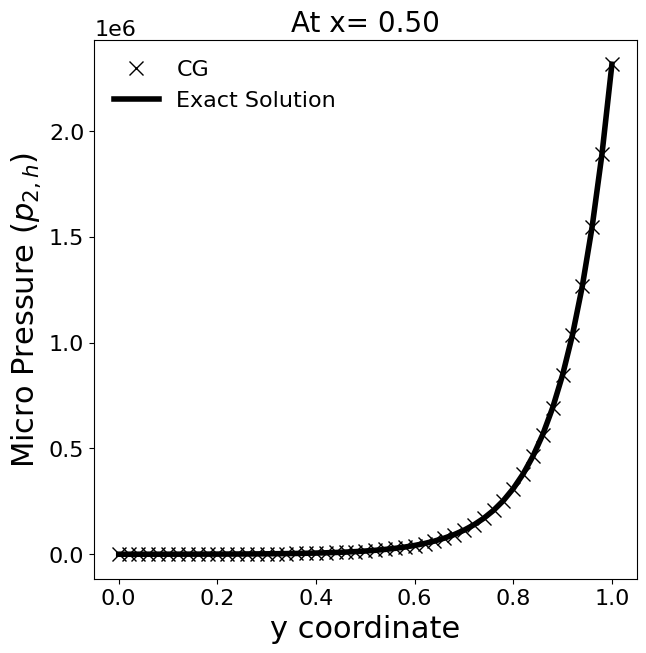

In [9]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(y_points, p1_at_x_mid_point, "x", ms=10, lw=4, c="k", label="CG")
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(y_points, p2_at_x_mid_point, "x", ms=10, lw=4, c="k", label="CG")
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

#### Scale-splitting

Pre-conditioner by scale:

In [10]:
# Approximation degree
degree = 1

# Function space declaration
pressure_family = "CG"
velocity_family = "CG"
U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
V = fd.FunctionSpace(mesh, pressure_family, degree)
W = V * V

# Trial and test functions
dpp_fields = fd.Function(W)
p1, p2 = fd.TrialFunctions(W)
q1, q2 = fd.TestFunctions(W)

# Forcing function
f = fd.Constant(0.0)

# Dirichlet BCs
bc_macro = fd.DirichletBC(W.sub(0), p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(W.sub(1), p2_exact, "on_boundary")
bcs = [bc_macro, bc_micro]

# Variational form
## Mass transfer term
xi = -beta / mu * (p1 - p2)

## Macro terms
a = (k1 / mu) * inner(grad(p1), grad(q1)) * dx - xi * q1 * dx
L = f * q1 * dx

## Micro terms
a += (k2 / mu) * inner(grad(p2), grad(q2)) * dx + xi * q2 * dx
L += f * q2 * dx

# Solving the problem
solver_parameters = {
    "snes_type": "ksponly",
    "ksp_monitor": None,
    "pmat_type": "aij",
    "mat_type": "aij",
    "ksp_type": "gmres",
    "ksp_rtol": 1.0e-12,
    "ksp_atol": 1.0e-12,
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
    "pc_fieldsplit_0_fields": "0",
    "pc_fieldsplit_1_fields": "1",
    "fieldsplit_0": {
        "mat_type": "aij",
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
    "fieldsplit_1": {
        "mat_type": "aij",
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
solution = fd.Function(W)
problem = fd.LinearVariationalProblem(a, L, solution, bcs=bcs, constant_jacobian=True)
solver = fd.LinearVariationalSolver(
    problem, solver_parameters=solver_parameters, options_prefix="dpp"
)
solver.solve()

# Retrieving the solution
p1_h = fd.Function(V, name="p1_h")
p2_h = fd.Function(V, name="p2_h")
p1_h.assign(solution.sub(0))
p2_h.assign(solution.sub(1))
u1_h = fd.project(-grad(p1_h), U)
u2_h = fd.project(-grad(p2_h), U)

    Residual norms for dpp_ solve.
    0 KSP Residual norm 2.294663950703e+07
    1 KSP Residual norm 3.044014355418e+05
    2 KSP Residual norm 4.628396134669e+03
    3 KSP Residual norm 2.886838585717e+01
    4 KSP Residual norm 7.015601684550e-02
    5 KSP Residual norm 8.094167503580e-05
    6 KSP Residual norm 6.201617153295e-08


In [11]:
solver_parameters_gmres = {
    "mat_type": "aij",
    "pc_type": "jacobi",
    "ksp_type": "gmres",
    "ksp_rtol": 1.0e-12,
    "ksp_atol": 1.0e-12,
    "ksp_max_it": 5000,
    "ksp_monitor": None,
}
solution_gmres = fd.Function(W)
problem_gmres = fd.LinearVariationalProblem(
    a, L, solution_gmres, bcs=bcs, constant_jacobian=True
)
solver_gmres = fd.LinearVariationalSolver(
    problem_gmres, solver_parameters=solver_parameters_gmres
)
solver_gmres.solve()

    Residual norms for firedrake_5_ solve.
    0 KSP Residual norm 6.309856739731e+06
    1 KSP Residual norm 2.760144706441e+06
    2 KSP Residual norm 1.600183135159e+06
    3 KSP Residual norm 1.050490593517e+06
    4 KSP Residual norm 7.388077837197e+05
    5 KSP Residual norm 5.424877816629e+05
    6 KSP Residual norm 4.098180210938e+05
    7 KSP Residual norm 3.156660887028e+05
    8 KSP Residual norm 2.465465809623e+05
    9 KSP Residual norm 1.944930514695e+05
   10 KSP Residual norm 1.545349326284e+05
   11 KSP Residual norm 1.234477895313e+05
   12 KSP Residual norm 9.900565184081e+04
   13 KSP Residual norm 7.963087088208e+04
   14 KSP Residual norm 6.418875868122e+04
   15 KSP Residual norm 5.182543851593e+04
   16 KSP Residual norm 4.189147332450e+04
   17 KSP Residual norm 3.389220852742e+04
   18 KSP Residual norm 2.743820777307e+04
   19 KSP Residual norm 2.222241457325e+04
   20 KSP Residual norm 1.800398665685e+04
   21 KSP Residual norm 1.458924504071e+04
   22 KSP R

In [12]:
# Fixed x-point coordinate to slice the solution
x_points, y_points = get_xy_coordinate_points(V, mesh)
x_mid_point = (x_points.min() + x_points.max()) / 2

p1_at_x_mid_point = retrieve_solution_on_line_fixed_x(p1_h, V, mesh, x_mid_point)

p2_at_x_mid_point = retrieve_solution_on_line_fixed_x(p2_h, V, mesh, x_mid_point)

p1_exact_at_x_mid_point = retrieve_solution_on_line_fixed_x(
    p1_exact, V, mesh, x_mid_point
)

p2_exact_at_x_mid_point = retrieve_solution_on_line_fixed_x(
    p2_exact, V, mesh, x_mid_point
)

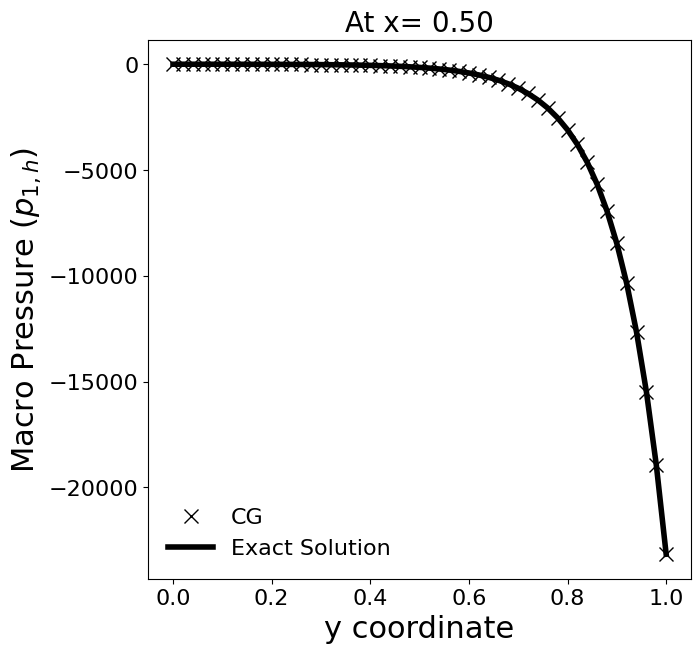

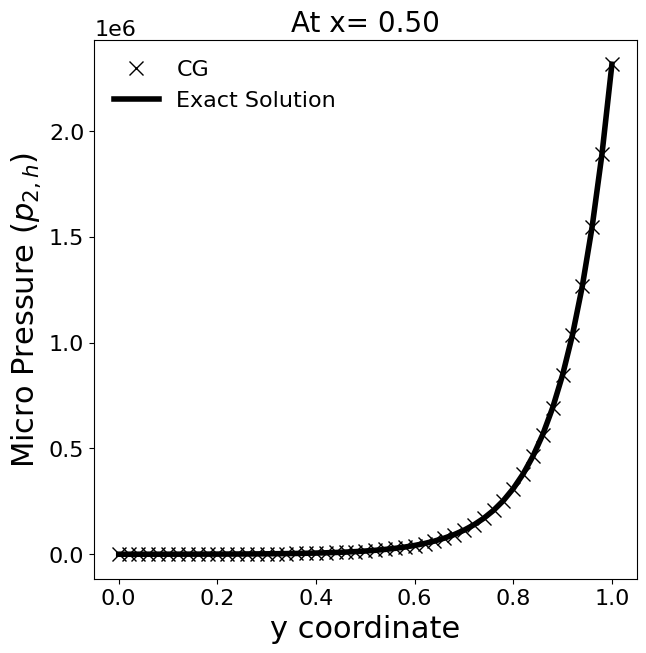

In [13]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(y_points, p1_at_x_mid_point, "x", ms=10, lw=4, c="k", label="CG")
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(y_points, p2_at_x_mid_point, "x", ms=10, lw=4, c="k", label="CG")
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

Picard (fixed-point) iterations:

In [14]:
# Approximation degree
degree = 1

# Function space declaration
pressure_family = "CG"
velocity_family = "CG"
U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
V = fd.FunctionSpace(mesh, pressure_family, degree)
W = V * V

# Trial and test functions
dpp_fields = fd.Function(W)
p1, p2 = fd.split(dpp_fields)
q1, q2 = fd.TestFunctions(W)

# Forcing function
f = fd.Constant(0.0)

# Dirichlet BCs
bc_macro = fd.DirichletBC(W.sub(0), p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(W.sub(1), p2_exact, "on_boundary")
bcs = [bc_macro, bc_micro]

# Variational form
## Mass transfer term
xi = -beta / mu * (p1 - p2)

## Macro terms
a = (k1 / mu) * inner(grad(p1), grad(q1)) * dx - xi * q1 * dx
L = f * q1 * dx

## Micro terms
a += (k2 / mu) * inner(grad(p2), grad(q2)) * dx + xi * q2 * dx
L += f * q2 * dx

solver_parameters_picard = {
    # Iteration monitoring
    "snes_monitor": None,
    # Set nonlinear Richardson (equivalent to Picard)
    "snes_type": "nrichardson",
    "snes_max_it": 50000,
    # The simplest line-search (no extra damping)
    "snes_linesearch_type": "basic",
    "snes_linesearch_damping": 0.5,  # for full step, use 1.0
    # Split by scales
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
    "pc_fieldsplit_0_fields": "0",  # macro
    "pc_fieldsplit_1_fields": "1",  # micro
    # Set the LU solver for each block
    "fieldsplit_0_ksp_type": "preonly",
    "fieldsplit_0_pc_type": "lu",
    "fieldsplit_0_pc_factor_mat_solver_type": "mumps",
    "fieldsplit_1_ksp_type": "preonly",
    "fieldsplit_1_pc_type": "lu",
    "fieldsplit_1_pc_factor_mat_solver_type": "mumps",
    # Convergence criteria
    "snes_rtol": 1e-5,  # rel tol between Picard iterations
    "snes_atol": 1e-12,
}

F = a - L
problem_picard = fd.NonlinearVariationalProblem(F, dpp_fields, bcs=bcs)
solver_picard = fd.NonlinearVariationalSolver(
    problem_picard, solver_parameters=solver_parameters_picard
)
solver_picard.solve()

  0 SNES Function norm 2.395327690102e+05
  1 SNES Function norm 1.874461810563e+05
  2 SNES Function norm 1.760724174656e+05
  3 SNES Function norm 1.706654731052e+05
  4 SNES Function norm 1.671352983735e+05
  5 SNES Function norm 1.644130829844e+05
  6 SNES Function norm 1.621095690194e+05
  7 SNES Function norm 1.600525559036e+05
  8 SNES Function norm 1.581552557690e+05
  9 SNES Function norm 1.563695929554e+05
 10 SNES Function norm 1.546669406959e+05
 11 SNES Function norm 1.530292434629e+05
 12 SNES Function norm 1.514445609330e+05
 13 SNES Function norm 1.499046740461e+05
 14 SNES Function norm 1.484037255369e+05
 15 SNES Function norm 1.469374114217e+05
 16 SNES Function norm 1.455024809758e+05
 17 SNES Function norm 1.440964169418e+05
 18 SNES Function norm 1.427172249565e+05
 19 SNES Function norm 1.413632913061e+05
 20 SNES Function norm 1.400332846409e+05
 21 SNES Function norm 1.387260866802e+05
 22 SNES Function norm 1.374407424653e+05
 23 SNES Function norm 1.361764240

In [15]:
# Retrieving the solution
p1_h = fd.Function(V, name="p1_h")
p2_h = fd.Function(V, name="p2_h")
p1_h.assign(dpp_fields.sub(0))
p2_h.assign(dpp_fields.sub(1))
u1_h = fd.project(-grad(p1_h), U)
u2_h = fd.project(-grad(p2_h), U)

# Fixed x-point coordinate to slice the solution
x_points, y_points = get_xy_coordinate_points(V, mesh)
x_mid_point = (x_points.min() + x_points.max()) / 2

p1_at_x_mid_point = retrieve_solution_on_line_fixed_x(p1_h, V, mesh, x_mid_point)

p2_at_x_mid_point = retrieve_solution_on_line_fixed_x(p2_h, V, mesh, x_mid_point)

p1_exact_at_x_mid_point = retrieve_solution_on_line_fixed_x(
    p1_exact, V, mesh, x_mid_point
)

p2_exact_at_x_mid_point = retrieve_solution_on_line_fixed_x(
    p2_exact, V, mesh, x_mid_point
)

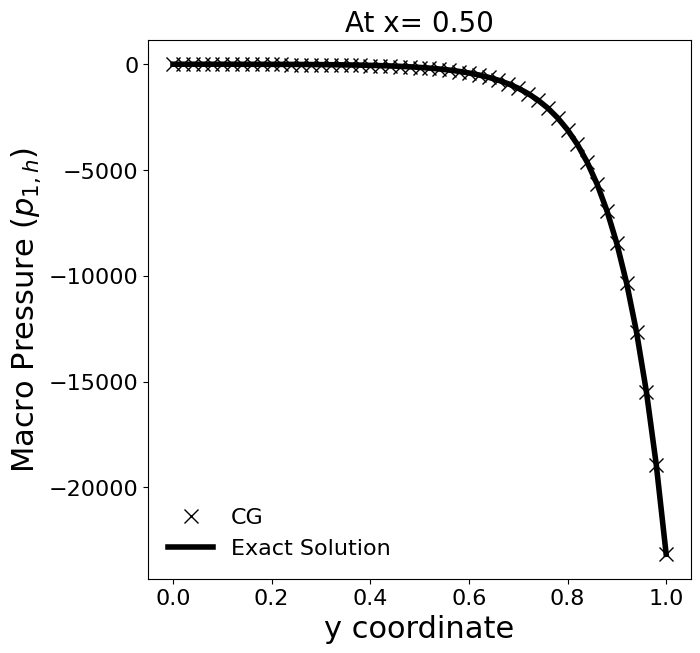

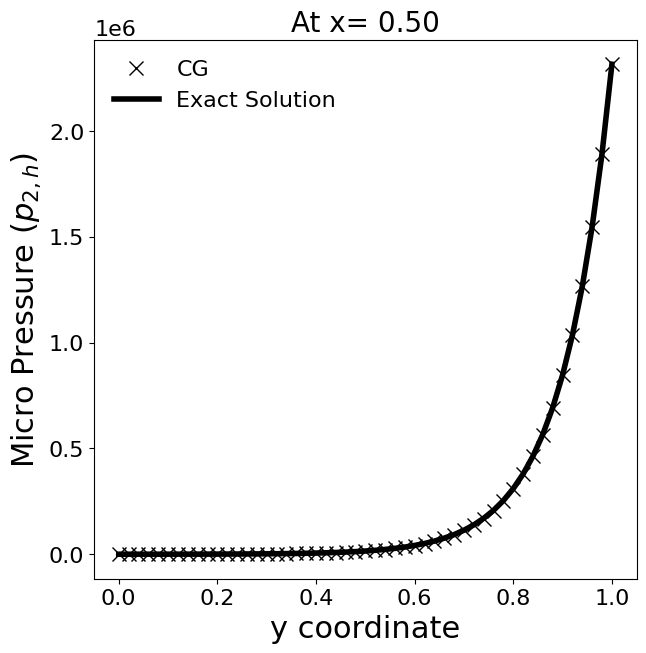

In [16]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(y_points, p1_at_x_mid_point, "x", ms=10, lw=4, c="k", label="CG")
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(y_points, p2_at_x_mid_point, "x", ms=10, lw=4, c="k", label="CG")
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

Loop-based Picard fixed-point iterations:

In [17]:
# Approximation degree
degree = 1

# Function space declaration
pressure_family = "CG"
velocity_family = "CG"
U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
V = fd.FunctionSpace(mesh, pressure_family, degree)

# Trial and test functions
p1 = fd.TrialFunction(V)
p2 = fd.TrialFunction(V)
q1 = fd.TestFunction(V)
q2 = fd.TestFunction(V)

# Forcing function
f = fd.Constant(0.0)

# Dirichlet BCs
bc_macro = fd.DirichletBC(V, p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(V, p2_exact, "on_boundary")

# Staggered pressures
p1_old = fd.interpolate(fd.Constant(0), V)
p2_old = fd.interpolate(fd.Constant(0), V)

# Variational form
## Mass transfer term
xi_macro = -beta / mu * (p1 - p2_old)
xi_micro = -beta / mu * (p1_old - p2)

## Macro terms
a_1 = (k1 / mu) * inner(grad(p1), grad(q1)) * dx - xi_macro * q1 * dx
L_1 = f * q1 * dx
F_macro = a_1 - L_1
a_macro = fd.lhs(F_macro)
L_macro = fd.rhs(F_macro)

## Micro terms
a_2 = (k2 / mu) * inner(grad(p2), grad(q2)) * dx + xi_micro * q2 * dx
L_2 = f * q2 * dx
F_micro = a_2 - L_2
a_micro = fd.lhs(F_micro)
L_micro = fd.rhs(F_micro)

# Solving the problem for each scale with Picard iterations

## Solver parameters: both scales with LU
solver_parameters = {
    "mat_type": "aij",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
}

## Macro
solution_macro = fd.Function(V)
problem_macro = fd.LinearVariationalProblem(
    a_macro, L_macro, solution_macro, bcs=[bc_macro], constant_jacobian=True
)
solver_macro = fd.LinearVariationalSolver(
    problem_macro, solver_parameters=solver_parameters
)

## Micro
solution_micro = fd.Function(V)
problem_micro = fd.LinearVariationalProblem(
    a_micro, L_micro, solution_micro, bcs=[bc_micro], constant_jacobian=True
)
solver_micro = fd.LinearVariationalSolver(
    problem_micro, solver_parameters=solver_parameters
)

## Picard loop
rtol, maxit = 1e-12, 10000
damping_parameter = fd.Constant(1)
for i in range(1, maxit + 1):
    # Macro sub-system
    solver_macro.solve()  # macro with micro fixed
    p1_old_k = p1_old.copy(deepcopy=True)
    p1_old.assign((1 - damping_parameter) * p1_old + damping_parameter * solution_macro)

    # Micro sub-system
    solver_micro.solve()  # micro with macro fixed
    p2_old_k = p2_old.copy(deepcopy=True)
    p2_old.assign((1 - damping_parameter) * p2_old + damping_parameter * solution_micro)

    # Errors and residuals
    p1_residual = fd.norm(solution_macro - p1_old_k)
    p2_residual = fd.norm(solution_micro - p2_old_k)
    p1_rel_error = p1_residual / fd.norm(solution_macro)
    p2_rel_error = p2_residual / fd.norm(solution_micro)
    print(
        f"Picard iteration: {i}; p1 rel error = {p1_rel_error}; p2 rel error = {p2_rel_error}"
    )

    # Convergence check
    if max(p1_rel_error, p2_rel_error) < rtol:
        print(f"Converged in {i} Picard steps")
        break

    # Update fully staggered pressures according to Picard's fixed-point method
    # p1_old.assign((1 - damping_parameter) * p1_old + damping_parameter * solution_macro)
    # p2_old.assign((1 - damping_parameter) * p2_old + damping_parameter * solution_micro)
else:
    print("Picard did not converge in", maxit)

/home/diego/dpp-studies/.venv/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.
/home/diego/dpp-studies/.venv/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `inter

Picard iteration: 1; p1 rel error = 1.0000000000000002; p2 rel error = 0.9999999999999996
Picard iteration: 2; p1 rel error = 0.964329630555279; p2 rel error = 0.007262549682593505
Picard iteration: 3; p1 rel error = 0.030814625081185185; p2 rel error = 0.0002550391572734441
Picard iteration: 4; p1 rel error = 0.0012133632105847073; p2 rel error = 1.0122704044866662e-05
Picard iteration: 5; p1 rel error = 4.8727931832196016e-05; p2 rel error = 4.068640954201067e-07
Picard iteration: 6; p1 rel error = 1.9610042923001383e-06; p2 rel error = 1.6375315568701644e-08
Picard iteration: 7; p1 rel error = 7.893658222546854e-08; p2 rel error = 6.591644477916389e-10
Picard iteration: 8; p1 rel error = 3.177524311089302e-09; p2 rel error = 2.653413282373098e-11
Picard iteration: 9; p1 rel error = 1.2790883375613305e-10; p2 rel error = 1.068114222263418e-12
Picard iteration: 10; p1 rel error = 5.148965242089246e-12; p2 rel error = 4.299702588720206e-14
Picard iteration: 11; p1 rel error = 2.0728438

In [18]:
# Retrieving the solution
p1_h = solution_macro
p2_h = solution_micro
u1_h = fd.project(-grad(p1_h), U)
u2_h = fd.project(-grad(p2_h), U)

# Fixed x-point coordinate to slice the solution
x_points, y_points = get_xy_coordinate_points(V, mesh)
x_mid_point = (x_points.min() + x_points.max()) / 2

p1_at_x_mid_point = retrieve_solution_on_line_fixed_x(p1_h, V, mesh, x_mid_point)

p2_at_x_mid_point = retrieve_solution_on_line_fixed_x(p2_h, V, mesh, x_mid_point)

p1_exact_at_x_mid_point = retrieve_solution_on_line_fixed_x(
    p1_exact, V, mesh, x_mid_point
)

p2_exact_at_x_mid_point = retrieve_solution_on_line_fixed_x(
    p2_exact, V, mesh, x_mid_point
)

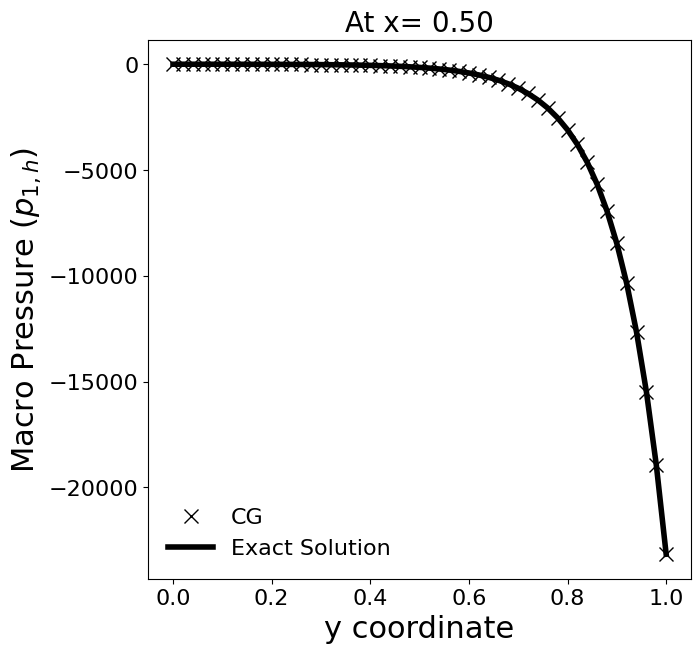

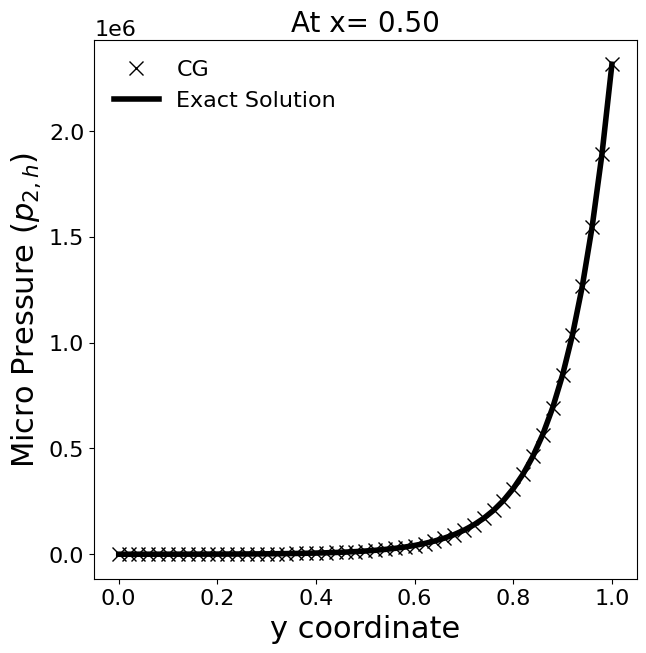

In [19]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(y_points, p1_at_x_mid_point, "x", ms=10, lw=4, c="k", label="CG")
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(y_points, p2_at_x_mid_point, "x", ms=10, lw=4, c="k", label="CG")
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

#### Conditioning Analysis

##### Monolithic system

Define the variational form:

In [20]:
# Approximation degree
degree = 1

# Function space declaration
pressure_family = "CG"
velocity_family = "CG"
U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
V = fd.FunctionSpace(mesh, pressure_family, degree)
W = V * V

# Trial and test functions
dpp_fields = fd.Function(W)
p1, p2 = fd.TrialFunctions(W)
q1, q2 = fd.TestFunctions(W)

# Forcing function
f = fd.Constant(0.0)

# Dirichlet BCs
bc_macro = fd.DirichletBC(W.sub(0), p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(W.sub(1), p2_exact, "on_boundary")
bcs = [bc_macro, bc_micro]

# Variational form
## Mass transfer term
xi = -beta / mu * (p1 - p2)

## Macro terms
a = (k1 / mu) * inner(grad(p1), grad(q1)) * dx - xi * q1 * dx
L = f * q1 * dx

## Micro terms
a += (k2 / mu) * inner(grad(p2), grad(q2)) * dx + xi * q2 * dx
L += f * q2 * dx

# Isolate LHS
F = a - L
a_form = fd.lhs(F)

Assemble and get the associated matrix:

In [21]:
A = fd.assemble(a_form, bcs=bcs, mat_type="aij")
petsc_mat = A.M.handle
is_symmetric = petsc_mat.isSymmetric(tol=1e-8)
size = petsc_mat.getSize()
Mnp = csr_matrix(petsc_mat.getValuesCSR()[::-1], shape=size)

Get DoF number and clean matrix:

In [22]:
Mnp.eliminate_zeros()
nnz = Mnp.nnz
number_of_dofs = W.dim()
num_of_factors = int(number_of_dofs) - 1

print(f"Number of Degrees of Freedom: {number_of_dofs}")
print(f"Number of non-zero entries: {nnz}")
print(f"Is operator symmetric? {is_symmetric}")
print(f"Number of factors to compute in SVD: {num_of_factors}")

Number of Degrees of Freedom: 5202
Number of non-zero entries: 84500
Is operator symmetric? True
Number of factors to compute in SVD: 5201


Convenient function to calculate spectral Condition Number using `scipy`:

In [23]:
def calculate_condition_number(
    A: petsc4py.PETSc.Mat,
    num_of_factors: int,
    use_sparse: bool = False,
    zero_tol: float = 1e-5,
) -> float | np.float64:
    size = A.getSize()
    Mnp = csr_matrix(A.getValuesCSR()[::-1], shape=size)
    Mnp.eliminate_zeros()

    if use_sparse:
        singular_values = svds(
            A=Mnp,
            k=num_of_factors,
            which="LM",
            maxiter=5000,
            return_singular_vectors=False,
            solver="lobpcg",
        )
    else:
        M = Mnp.toarray()
        singular_values = svd(M, compute_uv=False, check_finite=False)

    singular_values = singular_values[singular_values > zero_tol]

    condition_number = singular_values.max() / singular_values.min()

    return condition_number

Condition Number for the monolithic (all scales) matrix system:

In [24]:
monolithic_system_condition_number = calculate_condition_number(
    A=petsc_mat, num_of_factors=num_of_factors
)

print(f"Monolithic system Condition Number: {monolithic_system_condition_number}")

Monolithic system Condition Number: 8722.993706018511


##### Scale-splitting

In [25]:
# Approximation degree
degree = 1

# Function space declaration
pressure_family = "CG"
velocity_family = "CG"
U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
V = fd.FunctionSpace(mesh, pressure_family, degree)

# Trial and test functions
p1 = fd.TrialFunction(V)
p2 = fd.TrialFunction(V)
q1 = fd.TestFunction(V)
q2 = fd.TestFunction(V)

# Forcing function
f = fd.Constant(0.0)

# Dirichlet BCs
bc_macro = fd.DirichletBC(V, p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(V, p2_exact, "on_boundary")

# Staggered pressures
p1_old = fd.interpolate(fd.Constant(0), V)
p2_old = fd.interpolate(fd.Constant(0), V)

# Variational form
## Mass transfer term
xi_macro = -beta / mu * (p1 - p2_old)
xi_micro = -beta / mu * (p1_old - p2)

## Macro terms
a_1 = (k1 / mu) * inner(grad(p1), grad(q1)) * dx - xi_macro * q1 * dx
L_1 = f * q1 * dx
F_macro = a_1 - L_1
a_macro = fd.lhs(F_macro)
L_macro = fd.rhs(F_macro)

## Micro terms
a_2 = (k2 / mu) * inner(grad(p2), grad(q2)) * dx + xi_micro * q2 * dx
L_2 = f * q2 * dx
F_micro = a_2 - L_2
a_micro = fd.lhs(F_micro)
L_micro = fd.rhs(F_micro)

/home/diego/dpp-studies/.venv/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.


In [26]:
# Macro
A_macro = fd.assemble(a_macro, bcs=bc_macro, mat_type="aij")
petsc_mat_macro = A_macro.M.handle
is_symmetric_macro = petsc_mat_macro.isSymmetric(tol=1e-8)
size_macro = petsc_mat_macro.getSize()
Mnp_macro = csr_matrix(petsc_mat_macro.getValuesCSR()[::-1], shape=size_macro)

# Micro
A_micro = fd.assemble(a_micro, bcs=bc_micro, mat_type="aij")
petsc_mat_micro = A_micro.M.handle
is_symmetric_micro = petsc_mat_micro.isSymmetric(tol=1e-8)
size_micro = petsc_mat_micro.getSize()
Mnp_micro = csr_matrix(petsc_mat_micro.getValuesCSR()[::-1], shape=size_micro)

In [27]:
Mnp_macro.eliminate_zeros()
nnz = Mnp_macro.nnz
number_of_dofs = V.dim()
num_of_factors = int(number_of_dofs) - 1

print(f"Number of Degrees of Freedom (Macro): {number_of_dofs}")
print(f"Number of non-zero entries: {nnz}")
print(f"Is operator symmetric? {is_symmetric}")
print(f"Number of factors to compute in SVD: {num_of_factors}")

Number of Degrees of Freedom (Macro): 2601
Number of non-zero entries: 21225
Is operator symmetric? True
Number of factors to compute in SVD: 2600


In [28]:
Mnp_micro.eliminate_zeros()
nnz = Mnp_micro.nnz
number_of_dofs = V.dim()
num_of_factors = int(number_of_dofs) - 1

print(f"Number of Degrees of Freedom (Micro): {number_of_dofs}")
print(f"Number of non-zero entries: {nnz}")
print(f"Is operator symmetric? {is_symmetric}")
print(f"Number of factors to compute in SVD: {num_of_factors}")

Number of Degrees of Freedom (Micro): 2601
Number of non-zero entries: 21225
Is operator symmetric? True
Number of factors to compute in SVD: 2600


In [29]:
macro_system_condition_number = calculate_condition_number(
    A=petsc_mat_macro, num_of_factors=num_of_factors
)
micro_system_condition_number = calculate_condition_number(
    A=petsc_mat_micro, num_of_factors=num_of_factors
)

print(f"Macro system Condition Number: {macro_system_condition_number}")
print(f"Micro system Condition Number: {micro_system_condition_number}")

Macro system Condition Number: 482.04404487999267
Micro system Condition Number: 2090.506764304941
